<a href="https://colab.research.google.com/github/plthiyagu/AI-Engineering/blob/master/08-Deep%20Learning/Web_Traffic_Forecasting_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.analyticsvidhya.com/blog/2021/09/web-traffic-forecasting-using-deep-learning/?utm_source=feedburner&utm_medium=email&utm_campaign=Feed%3A+AnalyticsVidhya+%28Analytics+Vidhya%29

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/webtraffic.csv')

In [3]:
df.shape

(4896, 2)

In [4]:
df.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


In [5]:
import matplotlib.pyplot as plt
sessions = df['Sessions'].values

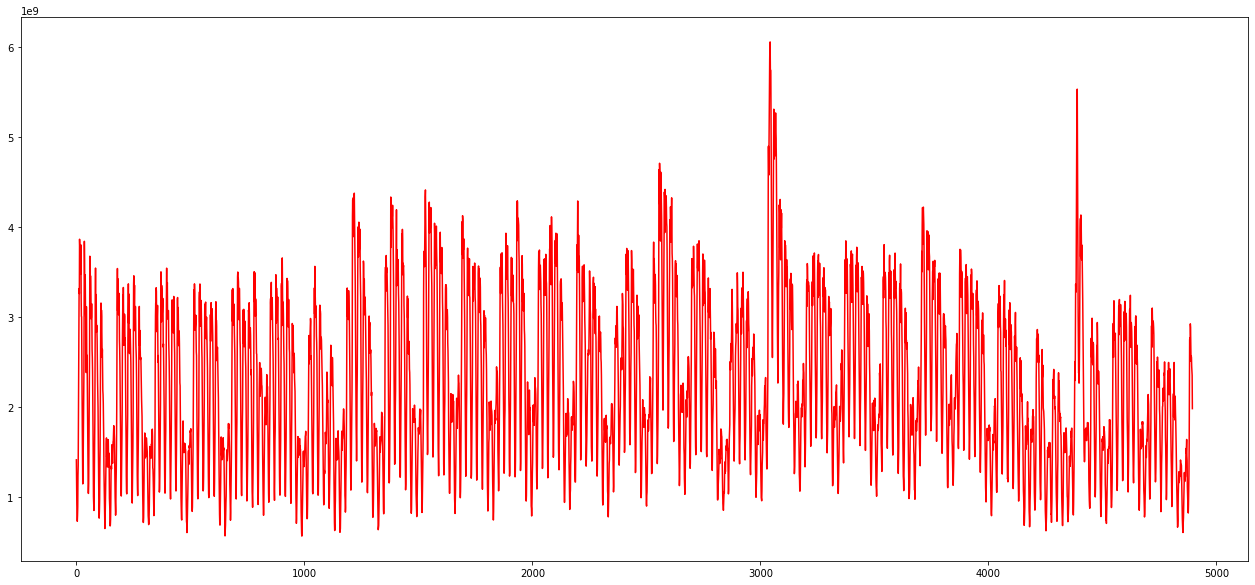

In [6]:
ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'r')
plt.show()

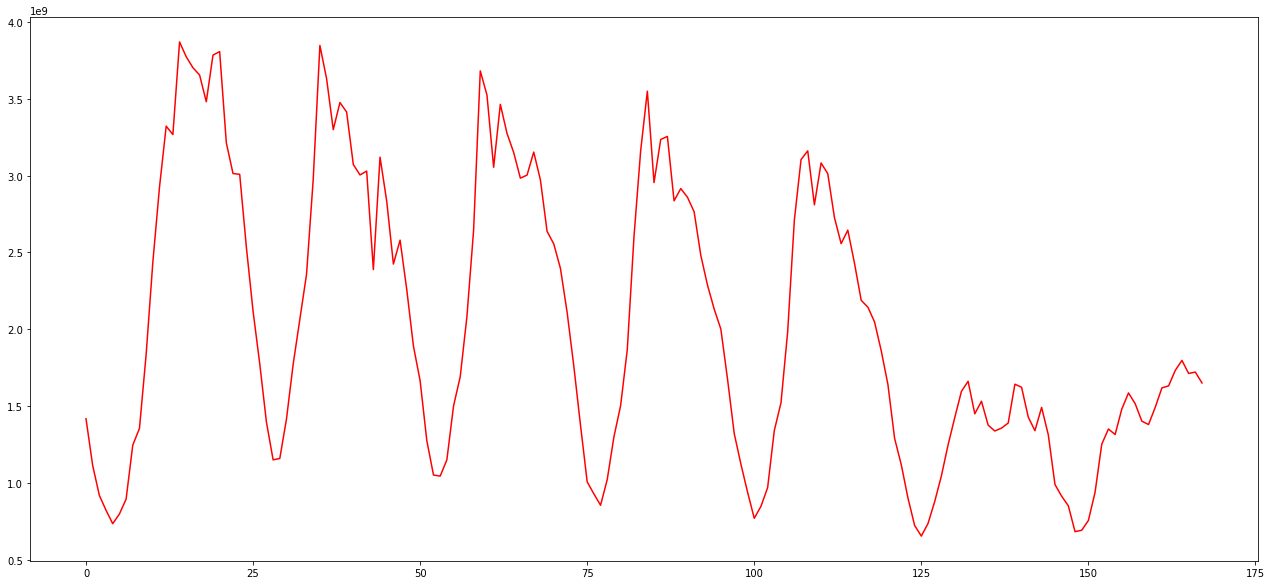

In [7]:
#first week web traffic
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'r')
plt.show()

In [11]:
def prepare_data(seq,num):
  x=[]
  y=[]
  for i in range(0,(len(seq)-num),1):
    input_ = seq[i:i+num]
    output  = seq[i+num]
    
    x.append(input_)
    y.append(output)
    
  return np.array(x), np.array(y)

In [12]:
num=168
x,y= prepare_data(sessions,num)
print(len(x))

4728


In [13]:
ind = int(0.9 * len(x))

In [14]:
x_tr = x[:ind]
y_tr = y[:ind]

In [15]:
x_val=x[ind:]
y_val=y[ind:]

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
#normalize the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

In [18]:
#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

In [19]:
#normalize the output
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

In [20]:
#reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)
print(x_tr.shape)

(4255, 168, 1)


In [21]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow import keras

In [22]:
# define model
model =  Sequential()
model.add(LSTM(128,input_shape=(168,1)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Define the optimizer and loss
model.compile(loss='mse',optimizer='adam')
#Define the callback to save the best model during the training
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss',
        verbose=1, save_best_only=True, mode='min')
# Train the model for 30 epochs with batch size of 32:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, 
           validation_data=(x_val,y_val), callbacks=[mc])

Epoch 1/30
133/133 [==============================] - 27s 181ms/step - loss: 0.1664 - val_loss: 0.0336

Epoch 00001: val_loss improved from inf to 0.03360, saving model to best_model.hdf5
Epoch 2/30
133/133 [==============================] - 22s 167ms/step - loss: 0.0436 - val_loss: 0.0271

Epoch 00002: val_loss improved from 0.03360 to 0.02713, saving model to best_model.hdf5
Epoch 3/30
133/133 [==============================] - 22s 168ms/step - loss: 0.0346 - val_loss: 0.0259

Epoch 00003: val_loss improved from 0.02713 to 0.02588, saving model to best_model.hdf5
Epoch 4/30
133/133 [==============================] - 23s 172ms/step - loss: 0.0325 - val_loss: 0.0231

Epoch 00004: val_loss improved from 0.02588 to 0.02306, saving model to best_model.hdf5
Epoch 5/30
133/133 [==============================] - 22s 169ms/step - loss: 0.0311 - val_loss: 0.0241

Epoch 00005: val_loss did not improve from 0.02306
Epoch 6/30
133/133 [==============================] - 25s 184ms/step - loss: 0.03

In [25]:
model.load_weights('best_model.hdf5')

In [ ]:
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

In [26]:
# build a simple moving average model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)

In [27]:
# reshape the data
x_reshaped = x_val.reshape(-1,168)

In [28]:
# get predictions
y_pred = compute_moving_average(x_reshaped)

In [29]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]
  #intialize the array with a weeks data
  temp=x_val[ind]
  for i in range(no_of_pred):
    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]
    
    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)
    #ignore the first element of array
    temp = temp[1:]
  return predictions

In [30]:
no_of_pred =24
ind=72
y_pred= forecast(x_val,no_of_pred,ind)
y_true = y_val[ind:ind+(no_of_pred)]
# Lets convert back the normalized values to the original dimensional space
y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)

In [31]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

In [ ]:
plot(y_true,y_pred)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [33]:
model= Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu',input_shape=(num,1)))
model.add(Conv1D(32, 5, padding='same', activation='relu',input_shape=(num,1)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 168, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 168, 32)           10272     
_________________________________________________________________
flatten (Flatten)            (None, 5376)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                344128    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 354,721
Trainable params: 354,721
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Define the optimizer and loss:
model.compile(loss='mse',optimizer='adam')
# Define the callback to save the best model during the training
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1,
         save_best_only=True, mode='min')
# Train the model for 30 epochs with batch size of 32:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, validation_data=(x_val,y_val),
            callbacks=[mc])

Epoch 1/30
133/133 [==============================] - 4s 26ms/step - loss: 0.0957 - val_loss: 0.0364

Epoch 00001: val_loss improved from inf to 0.03643, saving model to best_model.hdf5
Epoch 2/30
133/133 [==============================] - 3s 25ms/step - loss: 0.0255 - val_loss: 0.0242

Epoch 00002: val_loss improved from 0.03643 to 0.02416, saving model to best_model.hdf5
Epoch 3/30
133/133 [==============================] - 3s 25ms/step - loss: 0.0180 - val_loss: 0.0217

Epoch 00003: val_loss improved from 0.02416 to 0.02170, saving model to best_model.hdf5
Epoch 4/30
133/133 [==============================] - 3s 25ms/step - loss: 0.0159 - val_loss: 0.0204

Epoch 00004: val_loss improved from 0.02170 to 0.02043, saving model to best_model.hdf5
Epoch 5/30
133/133 [==============================] - 3s 26ms/step - loss: 0.0139 - val_loss: 0.0147

Epoch 00005: val_loss improved from 0.02043 to 0.01470, saving model to best_model.hdf5
Epoch 6/30
133/133 [==============================] - 

In [35]:
model.load_weights('best_model.hdf5')

In [36]:
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

15/15 [==============================] - 0s 7ms/step - loss: 0.0147
Mean Square Error: 0.014699913561344147


In [37]:
#build a simple model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)

In [38]:
x_reshaped = x_val.reshape(-1,168)
y_pred = compute_moving_average(x_reshaped)

In [39]:
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print("Mean Square Error:",mse)

Mean Square Error: 0.5546025834434455


In [40]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]
  #intialize the array with previous weeks data  
  temp=x_val[ind]
  for i in range(no_of_pred):
    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]
    
    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)
    #ignore the first element of array
    temp = temp[1:]
  return predictions

In [41]:
no_of_pred =24
ind=72
y_pred= forecast(x_val,no_of_pred,ind)
y_true = y_val[ind:ind+(no_of_pred)]
y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)

In [42]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()
